In [138]:
from konlpy.tag import Okt
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
from nltk import FreqDist
from functools import reduce
import os
import re
import matplotlib.pyplot as plt

In [139]:
okt = Okt()

In [140]:
TRAIN_FILE = os.path.join("about where/no_Q.txt")
TEST_FILE = os.path.join("about where/no_Q_TEST.txt")

In [141]:
i = 0
lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    i = i + 1
    print(line)
    if i == 20:
      break

1 필웅이는 화장실로 갔습니다.
2 은경이는 복도로 이동했습니다.
3 화장실	1
4 수종이는 복도로 복귀했습니다.
5 경임이는 정원으로 갔습니다.
6 복도	4
7 은경이는 사무실로 갔습니다.
8 경임이는 화장실로 뛰어갔습니다.
9 복도	4
10 필웅이는 복도로 갔습니다.
11 수종이는 사무실로 가버렸습니다.
12 사무실	11
13 은경이는 정원으로 복귀했습니다.
14 은경이는 침실로 갔습니다.
15 화장실	8
1 경임이는 사무실로 가버렸습니다.
2 경임이는 화장실로 이동했습니다.
3 화장실	2
4 필웅이는 침실로 이동했습니다.
5 수종이는 복도로 갔습니다.


In [142]:
def read_data(dir):
    stories, answers = [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []

        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, answers

In [143]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [144]:
train_stories, train_answers = read_data(TRAIN_FILE)
test_stories, test_answers = read_data(TEST_FILE)

In [145]:
print('훈련용 스토리의 개수 :', len(train_stories))
print('훈련용 답변의 개수 :',len(train_answers))
print('테스트용 스토리의 개수 :',len(test_stories))
print('테스트용 답변의 개수 :',len(test_answers))

훈련용 스토리의 개수 : 10000
훈련용 답변의 개수 : 10000
테스트용 스토리의 개수 : 1000
테스트용 답변의 개수 : 1000


In [146]:
def tokenize(sent):
    return [x.strip() for x in re.split('(\W+)?', sent) if x.strip()]

In [147]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()

    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []

    for stories, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어 집합 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)

    return word2idx, idx2word, story_max_len

In [148]:
word2idx, idx2word, story_max_len = preprocess_data(train_data, test_data)

In [149]:
vocab_size = len(word2idx) + 1

In [150]:
print('스토리의 최대 길이 :',story_max_len)

스토리의 최대 길이 : 40


In [151]:
def vectorize(data, word2idx, story_maxlen):
    Xs, Y = [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, answers = data
    for story, answer in zip(stories, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        Xs.append(xs)
        Y.append(word2idx[answer])
        # 스토리와 질문은 각각의 최대 길이로 패딩
        # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [152]:
Xstrain, Ytrain = vectorize(train_data, word2idx, story_max_len)
Xstest, Ytest = vectorize(test_data, word2idx, story_max_len)

In [153]:
print(Xstrain.shape, Ytrain.shape, Xstest.shape, Ytest.shape)

(10000, 40) (10000, 23) (1000, 40) (1000, 23)


In [168]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation
from tensorflow.keras import layers

In [186]:
# 에포크 횟수
train_epochs = 1000
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 과적합 방지 기법인 드롭아웃 적용 비율

In [187]:
model = Sequential()
model.add(layers.Dense(16,activation='relu',input_shape=(40,)))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(23,activation='sigmoid'))
print(model.summary())

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 16)                656       
_________________________________________________________________
dense_43 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_44 (Dense)             (None, 23)                391       
Total params: 1,319
Trainable params: 1,319
Non-trainable params: 0
_________________________________________________________________
None


In [188]:
# build the final model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])


# start training the model
history = model.fit(Xstrain,
         Ytrain, batch_size, train_epochs,
         validation_data=(Xstest, Ytest))

# save model
model.save('model.h5')

Epoch 1/1000
313/313 [==============================] - 1s 2ms/step - loss: 2.4472 - acc: 0.1485 - val_loss: 1.8064 - val_acc: 0.2260
Epoch 2/1000
313/313 [==============================] - 0s 1ms/step - loss: 1.7920 - acc: 0.2073 - val_loss: 1.7747 - val_acc: 0.2340
Epoch 3/1000
313/313 [==============================] - 0s 1ms/step - loss: 1.7665 - acc: 0.2282 - val_loss: 1.7704 - val_acc: 0.2410
Epoch 4/1000
313/313 [==============================] - 0s 1ms/step - loss: 1.7523 - acc: 0.2428 - val_loss: 1.7595 - val_acc: 0.2350
Epoch 5/1000
313/313 [==============================] - 0s 1ms/step - loss: 1.7291 - acc: 0.2432 - val_loss: 1.7330 - val_acc: 0.2540
Epoch 6/1000
313/313 [==============================] - 0s 1ms/step - loss: 1.7222 - acc: 0.2540 - val_loss: 1.7322 - val_acc: 0.2490
Epoch 7/1000
313/313 [==============================] - 0s 1ms/step - loss: 1.7080 - acc: 0.2608 - val_loss: 1.7294 - val_acc: 0.2480
Epoch 8/1000
313/313 [==============================] - 0s 907

In [182]:
print("\n 테스트 정확도: %.2f%%" % (model.evaluate([Xstest], Ytest)[1]*100))

32/32 [==============================] - 0s 1ms/step - loss: 1.5044 - acc: 0.4590

 테스트 정확도: 45.90%


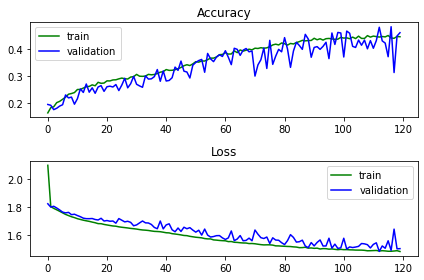

In [184]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest])
ytest_ = np.argmax(Ytest_, axis=1)

In [185]:
NUM_DISPLAY = 30

print("{:5}|{}".format("실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:7} {}".format(label, prediction))

실제값  |예측값
---------------------------------------
복도      화장실
화장실     화장실
부엌      부엌
복도      정원
부엌      부엌
복도      복도
정원      화장실
복도      복도
사무실     복도
사무실     화장실
부엌      부엌
정원      사무실
사무실     부엌
침실      정원
침실      침실
부엌      부엌
정원      정원
부엌      부엌
사무실     복도
부엌      정원
복도      복도
사무실     사무실
사무실     화장실
복도      침실
침실      사무실
침실      부엌
침실      침실
부엌      부엌
부엌      정원
부엌      부엌
